# Interpreting Deep Learning Models on Image Data

Here we will look at one of the newest frameworks (as on August, 2019) called `tf-explain` which offers a wide variety of techniques to explain vision based deep learning model predictions.

Following are the techniques showcased in this notebook.

- Visualize Activation Layers
- Occlusion Sensitivity
- Grad-CAM
- SmoothGrad

# Install Dependencies

In [1]:
!pip install tf-explain
!pip install pillow
!pip install tensorflow-gpu==2.0.0b1

# Load Dependencies

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions

%matplotlib inline

In [3]:
!nvidia-smi

Sun Aug  4 01:11:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
tf.__version__

'2.0.0-beta1'

In [5]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

True
/device:GPU:0


# Load pre-trained CNN - Xception Model

In [6]:
model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=True)
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

# Make Model Prediction on Sample Image

In [0]:
IMAGE_PATH = './cat2.jpg'

In [0]:
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)

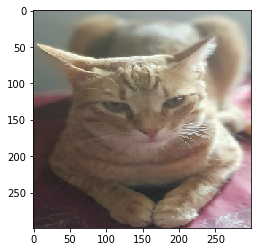

In [9]:
plt.imshow(img/255.)

In [0]:
import requests

response = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map = response.json()
imgnet_map = {v[1]: k for k, v in imgnet_map.items()}

In [0]:
img = tf.keras.applications.xception.preprocess_input(img)

In [12]:
predictions = model.predict(np.array([img]))
decode_predictions(predictions, top=5)

[[('n02124075', 'Egyptian_cat', 0.80723596),
  ('n02123159', 'tiger_cat', 0.09508163),
  ('n02123045', 'tabby', 0.042587988),
  ('n02127052', 'lynx', 0.00547999),
  ('n02971356', 'carton', 0.0014547487)]]

# Interpretation with Activation Layer Visualizations

Visualize how a given input comes out of specific activation layers. Explores which feature maps are getting activated in the model.

In [0]:
explainer = ExtractActivations()

### Block 1

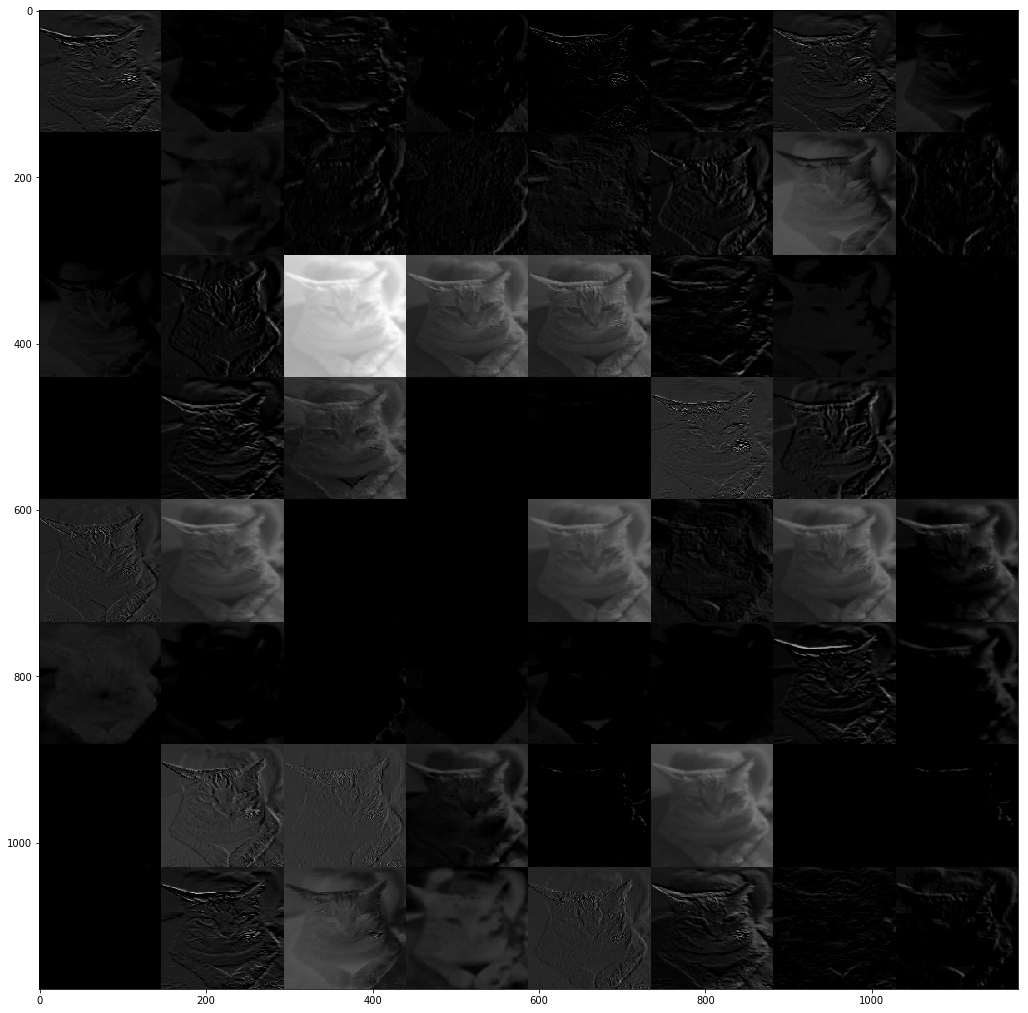

In [14]:
grid = explainer.explain((np.array([img]), None), model, ['block1_conv2_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

### Block 2

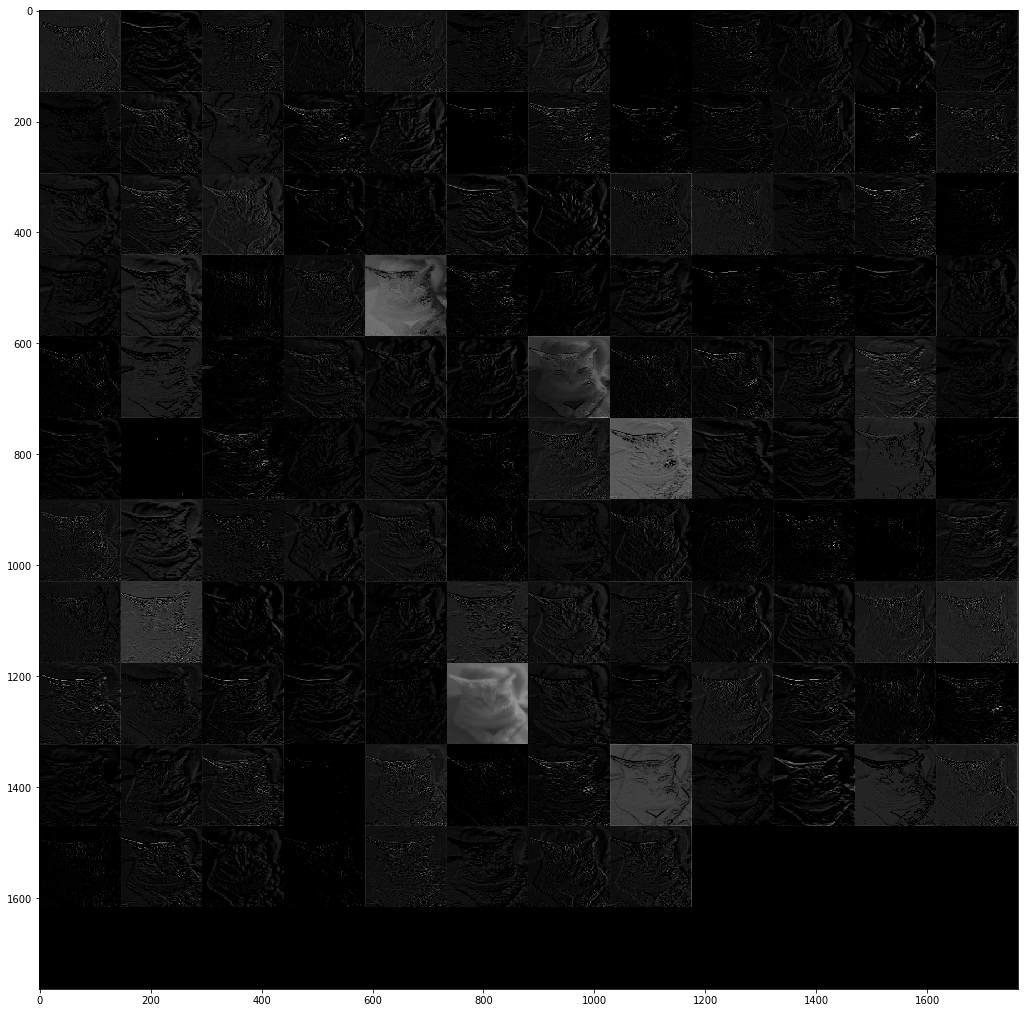

In [15]:
grid = explainer.explain((np.array([img]), None), model, ['block2_sepconv2_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

### Block 14

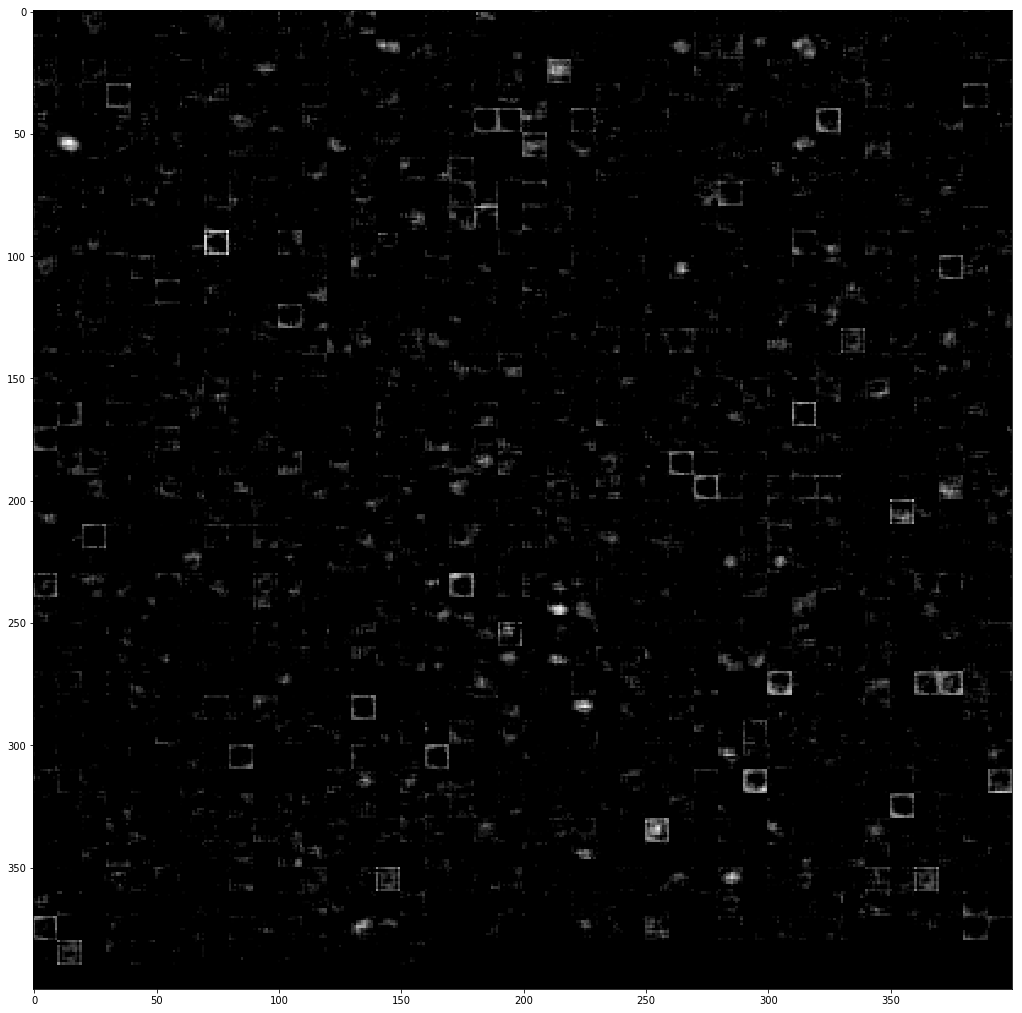

In [16]:
grid = explainer.explain((np.array([img]), None), model, ['block14_sepconv1_act'])
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(grid, cmap='binary_r')

# Interpretation with Occlusion Sensitivity

Visualize how parts of the image affects neural network's confidence by occluding parts iteratively. Done by systematically occluding different portions of the
input image with a grey square, and monitoring the
output of the classifier. 

In [17]:
imgnet_map['Egyptian_cat']

'285'

In [0]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

explainer = OcclusionSensitivity()

In [0]:
img_inp = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(299, 299))
img_inp = tf.keras.preprocessing.image.img_to_array(img_inp)

In [0]:
grid = explainer.explain(([img_inp], None), model, 285, 7)

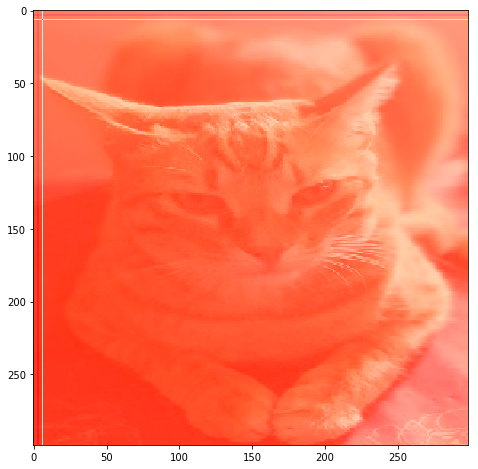

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(grid)#, alpha=1)

# Interpretation with GradCAM

Visualize how parts of the image affects neural network's output by looking into the class activation maps. Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

- The output of grad-cam will be pixels that contribute to the maximization of a target function. If for example you are interested in what maximizes category number 285, then zero out all the other categories.
- Compute the gradients of the target function, with respect to the convolutional layer outputs. This can be done effeciently with backpropagation

Given an image and a class of interest (e.g., ‘tiger cat’ or any other type of differentiable output) as input, we forward propagate the image through the CNN part of the model and then through task-specific computations to obtain a raw score for the category. 

The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the rectified convolutional feature maps of interest, which we combine to compute the coarse Grad-CAM localization (blue heatmap) which represents where the model has to look to make the particular decision

In [0]:
from tf_explain.core.grad_cam import GradCAM

In [0]:
explainer = GradCAM()

In [24]:
imgnet_map['tabby'], imgnet_map['Egyptian_cat']

('281', '285')

## Block 1

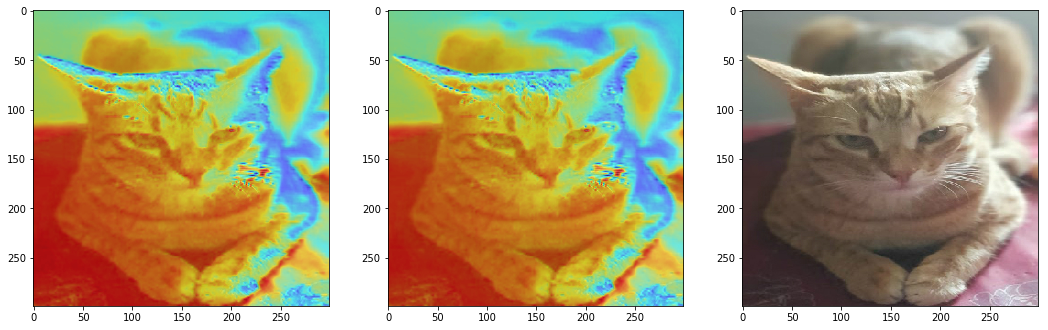

In [25]:
grid1 = explainer.explain(([img], None), model, 'block1_conv1', 281)
grid2 = explainer.explain(([img], None), model, 'block1_conv1', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

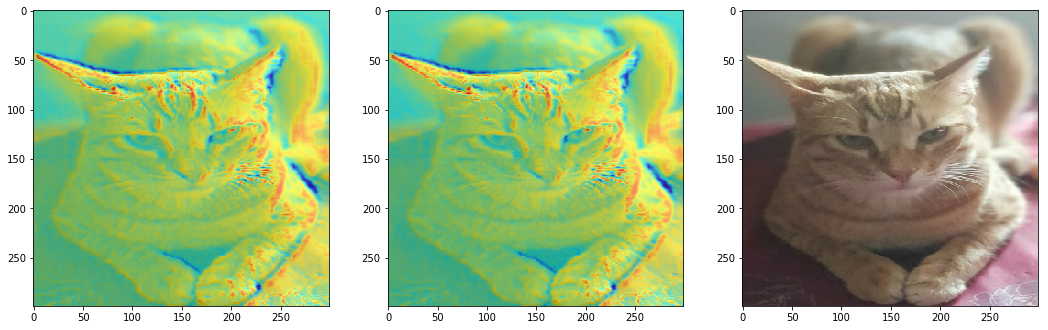

In [26]:
grid1 = explainer.explain(([img], None), model, 'block1_conv2', 281)
grid2 = explainer.explain(([img], None), model, 'block1_conv2', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 6

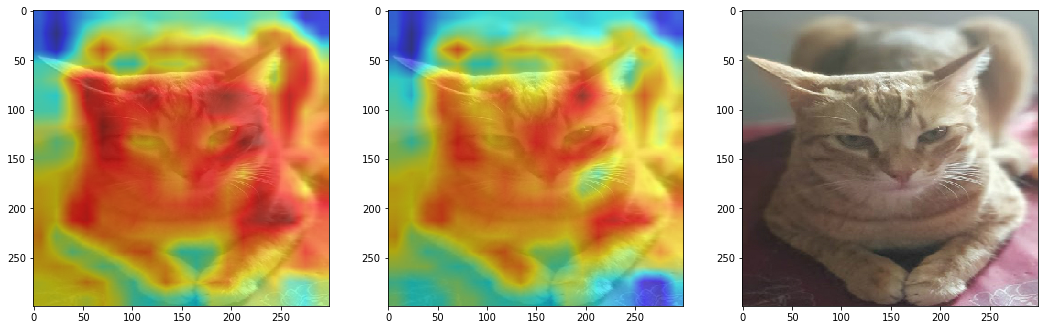

In [27]:
grid1 = explainer.explain(([img], None), model, 'block6_sepconv1', 281)
grid2 = explainer.explain(([img], None), model, 'block6_sepconv1', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 9

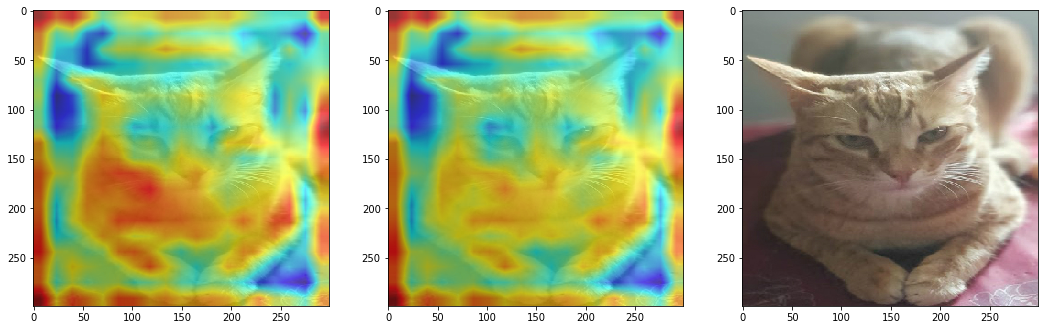

In [28]:
grid1 = explainer.explain(([img], None), model, 'block9_sepconv1', 281)
grid2 = explainer.explain(([img], None), model, 'block9_sepconv1', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 12

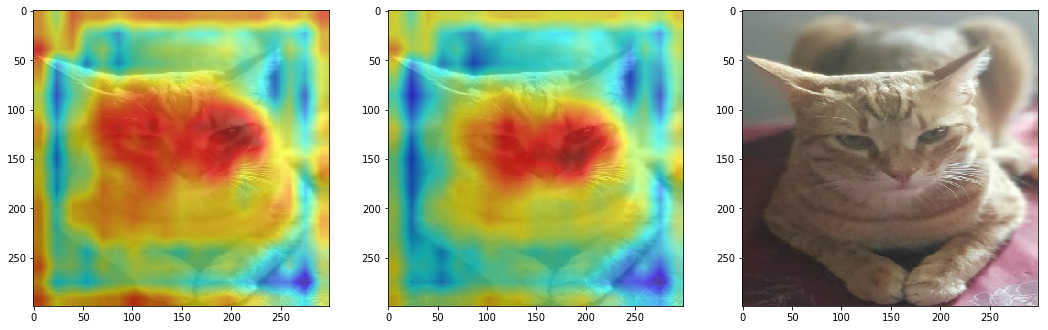

In [29]:
grid1 = explainer.explain(([img], None), model, 'block12_sepconv1', 281)
grid2 = explainer.explain(([img], None), model, 'block12_sepconv1', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

## Block 14

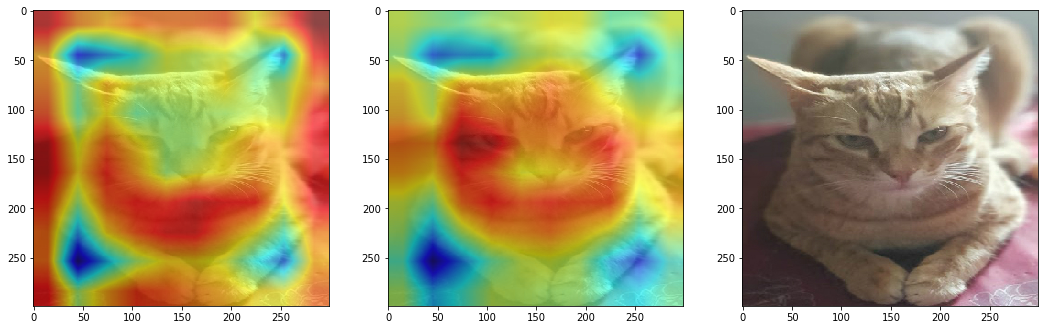

In [30]:
grid1 = explainer.explain(([img], None), model, 'block14_sepconv1', 281)
grid2 = explainer.explain(([img], None), model, 'block14_sepconv1', 285)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.6)

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.6)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)

# Interpretation with SmoothGrad

Visualize stabilized gradients on the inputs towards the decision. Identify pixels that strongly influence the final decision. 

A starting point for this strategy is the gradient of the class score function with respect to the input image. This gradient can be interpreted as a sensitivity map, and there are several techniques that elaborate on this basic idea. 

SmoothGrad is a simple method that can help visually sharpen gradient-based sensitivity maps.

The core idea is to take an image of interest, sample similar images by adding noise to the image, then take
the average of the resulting sensitivity maps for each sampled image.

In [0]:
from tf_explain.core.smoothgrad import SmoothGrad

explainer = SmoothGrad()

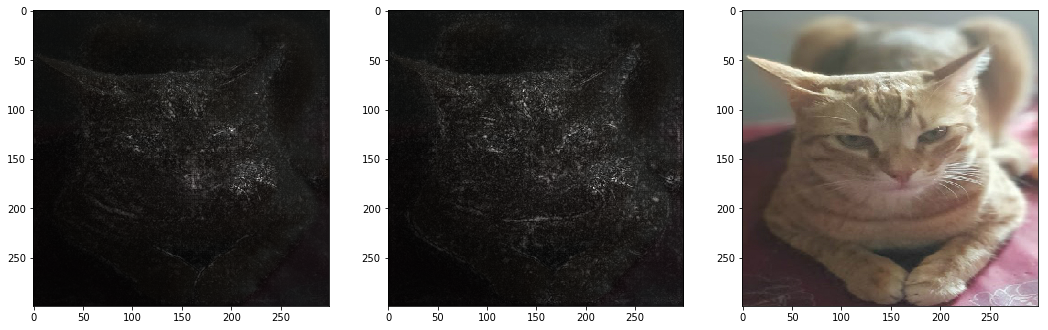

In [32]:
grid1 = explainer.explain(([img], None), model, 281, 80, .2)
grid2 = explainer.explain(([img], None), model, 285, 80, .2)

fig = plt.figure(figsize = (18, 8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img_inp / 255.)
ax1.imshow(grid1, alpha=0.9, cmap='binary_r')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img_inp / 255.)
ax2.imshow(grid2, alpha=0.9, cmap='binary_r')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_inp / 255.)